In [3]:
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.autograd import Variable
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import os
import cv2
from PIL import Image
from tqdm import tqdm_notebook as tqdm
import random
from matplotlib import pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [60]:
class ImageTransform():
    def __init__(self, resize, mean, std):
        self.data_transform= {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale=(0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ]),
            'val': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }
        
    def __call__(self, img, phase):
        return self.data_transform[phase](img)

In [101]:
cat_directory = r"./data/dogs-vs-cats/Cat/"
dog_directory = r"./data/dogs-vs-cats/Dog/"

cat_images_filepaths = sorted([os.path.join(cat_directory, f) for f in os.listdir(cat_directory)])
dog_images_filepaths = sorted([os.path.join(dog_directory, f) for f in os.listdir(dog_directory)])
images_filepaths = [*cat_images_filepaths, *dog_images_filepaths]
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]

random.seed(42)
random.shuffle(correct_images_filepaths)
train_images_filepaths = correct_images_filepaths[:400]
val_images_filepaths = correct_images_filepaths[400:-10]
test_images_filepaths = correct_images_filepaths[-10:]
print(len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths))


400 92 10


In [102]:
def display_image_grid(images_filepaths, predicted_labels=(), cols = 5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows = rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        print('path;;', image_filepath)
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        true_label = os.path.normpath(image_filepath).split(os.sep)[-2]
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        color = "green" if true_label == predicted_label else "red"
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(predicted_label, color = color)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

path;; ./data/dogs-vs-cats/Cat/cat.145.jpg
path;; ./data/dogs-vs-cats/Dog/dog.211.jpg
path;; ./data/dogs-vs-cats/Cat/cat.162.jpg
path;; ./data/dogs-vs-cats/Cat/cat.200.jpg
path;; ./data/dogs-vs-cats/Cat/cat.210.jpg
path;; ./data/dogs-vs-cats/Cat/cat.224.jpg
path;; ./data/dogs-vs-cats/Dog/dog.213.jpg
path;; ./data/dogs-vs-cats/Cat/cat.109.jpg
path;; ./data/dogs-vs-cats/Cat/cat.15.jpg
path;; ./data/dogs-vs-cats/Dog/dog.167.jpg


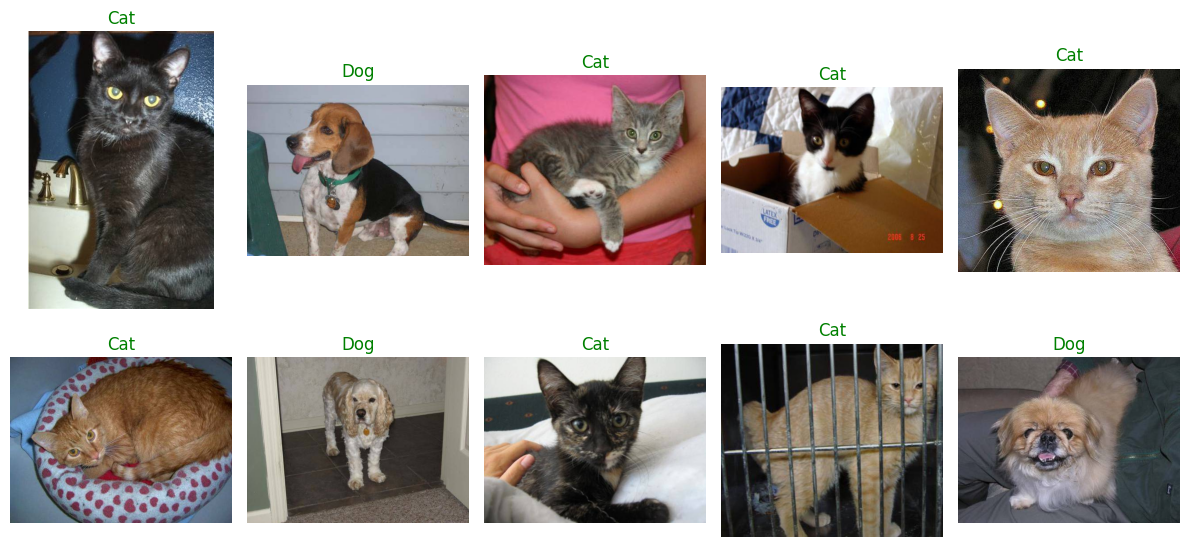

In [103]:
display_image_grid(test_images_filepaths)

In [119]:
class DogvsCatDataset(Dataset):
    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list
        self.transform = transform
        self.phase = phase
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img, self.phase)
        
        label = img_path.split('/')[-1].split('.')[0]
        if label == 'dog':
            label = 1
        elif label == 'cat':
            label = 0
      
        return img_transformed, label

In [105]:
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

In [107]:
train_dataset = DogvsCatDataset(train_images_filepaths, transform = ImageTransform(size, mean, std), phase = 'train')
val_dataset = DogvsCatDataset(val_images_filepaths, transform = ImageTransform(size, mean, std), phase = 'val')

index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

./data/dogs-vs-cats/Cat/cat.151.jpg
torch.Size([3, 224, 224])
./data/dogs-vs-cats/Cat/cat.151.jpg
0


In [108]:
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size = batch_size, shuffle=False)
dataloader_dict = {"train": train_dataloader, "val": val_dataloader}

batch_iterator = iter(train_dataloader)
inputs, label = next(batch_iterator)
print(inputs.size())
print(label)

./data/dogs-vs-cats/Cat/cat.74.jpg
./data/dogs-vs-cats/Dog/dog.40.jpg
./data/dogs-vs-cats/Dog/dog.18.jpg
./data/dogs-vs-cats/Dog/dog.34.jpg
./data/dogs-vs-cats/Dog/dog.224.jpg
./data/dogs-vs-cats/Dog/dog.16.jpg
./data/dogs-vs-cats/Dog/dog.190.jpg
./data/dogs-vs-cats/Cat/cat.238.jpg
./data/dogs-vs-cats/Dog/dog.175.jpg
./data/dogs-vs-cats/Dog/dog.246.jpg
./data/dogs-vs-cats/Cat/cat.212.jpg
./data/dogs-vs-cats/Dog/dog.174.jpg
./data/dogs-vs-cats/Cat/cat.181.jpg
./data/dogs-vs-cats/Dog/dog.118.jpg
./data/dogs-vs-cats/Dog/dog.207.jpg
./data/dogs-vs-cats/Cat/cat.35.jpg
./data/dogs-vs-cats/Dog/dog.105.jpg
./data/dogs-vs-cats/Dog/dog.222.jpg
./data/dogs-vs-cats/Cat/cat.225.jpg
./data/dogs-vs-cats/Cat/cat.182.jpg
./data/dogs-vs-cats/Dog/dog.36.jpg
./data/dogs-vs-cats/Cat/cat.179.jpg
./data/dogs-vs-cats/Cat/cat.131.jpg
./data/dogs-vs-cats/Dog/dog.25.jpg
./data/dogs-vs-cats/Dog/dog.156.jpg
./data/dogs-vs-cats/Cat/cat.246.jpg
./data/dogs-vs-cats/Dog/dog.102.jpg
./data/dogs-vs-cats/Dog/dog.66.jpg
.

In [109]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding = 0)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride = 1, padding = 0)
        
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        self.fc1 = nn.Linear(32*53*53, 512)
        self.relu5 = nn.ReLU()
        self.fc2 = nn.Linear(512, 2)
        self.output = nn.Softmax(dim=1)
        
    def forward(self, x):
        out = self.cnn1(x)
        out = self.relu1(out)
        out = self.maxpool1(out)
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        out = out.view(out.size(0), -1)
        
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.output(out)
        
        return out
    
        

In [110]:
model = LeNet()
print(model)

LeNet(
  (cnn1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=89888, out_features=512, bias=True)
  (relu5): ReLU()
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (output): Softmax(dim=1)
)


In [111]:
from torchsummary import summary
model = model.cuda()
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 220, 220]           1,216
              ReLU-2         [-1, 16, 220, 220]               0
         MaxPool2d-3         [-1, 16, 110, 110]               0
            Conv2d-4         [-1, 32, 106, 106]          12,832
              ReLU-5         [-1, 32, 106, 106]               0
         MaxPool2d-6           [-1, 32, 53, 53]               0
            Linear-7                  [-1, 512]      46,023,168
            Linear-8                    [-1, 2]           1,026
           Softmax-9                    [-1, 2]               0
Total params: 46,038,242
Trainable params: 46,038,242
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 19.47
Params size (MB): 175.62
Estimated Total Size (MB): 195.67
--------------------------------

In [112]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 46,038,242 trainable parameters


In [113]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [114]:
model = model.to(device)
criterion = criterion.to(device)

In [117]:
import time
def train_model(model, dataloader_dict, criterion, optimizer, num_epoch):
    since = time.time()
    best_acc = 0.0
    
    for epoch in range(num_epoch):
        print("Epoch {}/{}".format(epoch+1, num_epoch))
        print('-'*20)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            epoch_loss = 0.0
            epoch_corrects = 0
            
            for inputs, labels in tqdm(dataloader_dict[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data)
                
                epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
                epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset)
                
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
                
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = model.state_dict()
                    
    time_elapsed = time.time() - since
    print("Training complete in {:.0f}m {:.0f}s".format(
        time_elapsed // 60, time_elapsed % 60
    ))
    print("Best val acc: {:4f}".format(best_acc))
    
    return model

In [118]:
num_epoch = 10

model = train_model(model, dataloader_dict, criterion, optimizer, num_epoch)

Epoch 1/10
--------------------


C:\Users\sangil\AppData\Local\Temp\ipykernel_16904\3785032783.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for inputs, labels in tqdm(dataloader_dict[phase]):


  0%|          | 0/13 [00:00<?, ?it/s]

./data/dogs-vs-cats/Dog/dog.164.jpg
./data/dogs-vs-cats/Dog/dog.175.jpg
./data/dogs-vs-cats/Cat/cat.121.jpg
./data/dogs-vs-cats/Cat/cat.243.jpg
./data/dogs-vs-cats/Cat/cat.208.jpg
./data/dogs-vs-cats/Dog/dog.141.jpg
./data/dogs-vs-cats/Cat/cat.186.jpg
./data/dogs-vs-cats/Dog/dog.113.jpg
./data/dogs-vs-cats/Dog/dog.66.jpg
./data/dogs-vs-cats/Dog/dog.33.jpg
./data/dogs-vs-cats/Cat/cat.67.jpg
./data/dogs-vs-cats/Dog/dog.91.jpg
./data/dogs-vs-cats/Dog/dog.12.jpg
./data/dogs-vs-cats/Dog/dog.203.jpg
./data/dogs-vs-cats/Dog/dog.95.jpg
./data/dogs-vs-cats/Cat/cat.131.jpg
./data/dogs-vs-cats/Cat/cat.181.jpg
./data/dogs-vs-cats/Dog/dog.227.jpg
./data/dogs-vs-cats/Cat/cat.190.jpg
./data/dogs-vs-cats/Dog/dog.31.jpg
./data/dogs-vs-cats/Cat/cat.141.jpg
./data/dogs-vs-cats/Dog/dog.151.jpg
./data/dogs-vs-cats/Cat/cat.102.jpg
./data/dogs-vs-cats/Cat/cat.159.jpg
./data/dogs-vs-cats/Dog/dog.231.jpg
./data/dogs-vs-cats/Dog/dog.44.jpg
./data/dogs-vs-cats/Cat/cat.203.jpg
./data/dogs-vs-cats/Dog/dog.118.jpg


  0%|          | 0/3 [00:00<?, ?it/s]

./data/dogs-vs-cats/Dog/dog.45.jpg
./data/dogs-vs-cats/Dog/dog.152.jpg
./data/dogs-vs-cats/Cat/cat.130.jpg
./data/dogs-vs-cats/Dog/dog.170.jpg
./data/dogs-vs-cats/Dog/dog.187.jpg
./data/dogs-vs-cats/Dog/dog.72.jpg
./data/dogs-vs-cats/Cat/cat.220.jpg
./data/dogs-vs-cats/Dog/dog.181.jpg
./data/dogs-vs-cats/Cat/cat.195.jpg
./data/dogs-vs-cats/Cat/cat.36.jpg
./data/dogs-vs-cats/Cat/cat.43.jpg
./data/dogs-vs-cats/Cat/cat.173.jpg
./data/dogs-vs-cats/Cat/cat.40.jpg
./data/dogs-vs-cats/Dog/dog.165.jpg
./data/dogs-vs-cats/Cat/cat.82.jpg
./data/dogs-vs-cats/Dog/dog.88.jpg
./data/dogs-vs-cats/Dog/dog.51.jpg
./data/dogs-vs-cats/Cat/cat.144.jpg
./data/dogs-vs-cats/Dog/dog.8.jpg
./data/dogs-vs-cats/Dog/dog.39.jpg
./data/dogs-vs-cats/Cat/cat.231.jpg
./data/dogs-vs-cats/Dog/dog.228.jpg
./data/dogs-vs-cats/Cat/cat.202.jpg
./data/dogs-vs-cats/Dog/dog.177.jpg
./data/dogs-vs-cats/Cat/cat.119.jpg
./data/dogs-vs-cats/Cat/cat.13.jpg
./data/dogs-vs-cats/Dog/dog.197.jpg
./data/dogs-vs-cats/Cat/cat.187.jpg
./da

  0%|          | 0/13 [00:00<?, ?it/s]

./data/dogs-vs-cats/Dog/dog.225.jpg
./data/dogs-vs-cats/Dog/dog.9.jpg
./data/dogs-vs-cats/Cat/cat.73.jpg
./data/dogs-vs-cats/Cat/cat.122.jpg
./data/dogs-vs-cats/Cat/cat.218.jpg
./data/dogs-vs-cats/Dog/dog.131.jpg
./data/dogs-vs-cats/Cat/cat.151.jpg
./data/dogs-vs-cats/Cat/cat.27.jpg
./data/dogs-vs-cats/Dog/dog.226.jpg
./data/dogs-vs-cats/Dog/dog.175.jpg
./data/dogs-vs-cats/Dog/dog.122.jpg
./data/dogs-vs-cats/Cat/cat.35.jpg
./data/dogs-vs-cats/Dog/dog.236.jpg
./data/dogs-vs-cats/Cat/cat.110.jpg
./data/dogs-vs-cats/Cat/cat.96.jpg
./data/dogs-vs-cats/Dog/dog.82.jpg
./data/dogs-vs-cats/Dog/dog.200.jpg
./data/dogs-vs-cats/Dog/dog.139.jpg
./data/dogs-vs-cats/Cat/cat.157.jpg
./data/dogs-vs-cats/Cat/cat.161.jpg
./data/dogs-vs-cats/Dog/dog.230.jpg
./data/dogs-vs-cats/Dog/dog.17.jpg
./data/dogs-vs-cats/Cat/cat.189.jpg
./data/dogs-vs-cats/Cat/cat.21.jpg
./data/dogs-vs-cats/Cat/cat.215.jpg
./data/dogs-vs-cats/Dog/dog.212.jpg
./data/dogs-vs-cats/Dog/dog.135.jpg
./data/dogs-vs-cats/Cat/cat.176.jpg
.

  0%|          | 0/3 [00:00<?, ?it/s]

./data/dogs-vs-cats/Dog/dog.45.jpg
./data/dogs-vs-cats/Dog/dog.152.jpg
./data/dogs-vs-cats/Cat/cat.130.jpg
./data/dogs-vs-cats/Dog/dog.170.jpg
./data/dogs-vs-cats/Dog/dog.187.jpg
./data/dogs-vs-cats/Dog/dog.72.jpg
./data/dogs-vs-cats/Cat/cat.220.jpg
./data/dogs-vs-cats/Dog/dog.181.jpg
./data/dogs-vs-cats/Cat/cat.195.jpg
./data/dogs-vs-cats/Cat/cat.36.jpg
./data/dogs-vs-cats/Cat/cat.43.jpg
./data/dogs-vs-cats/Cat/cat.173.jpg
./data/dogs-vs-cats/Cat/cat.40.jpg
./data/dogs-vs-cats/Dog/dog.165.jpg
./data/dogs-vs-cats/Cat/cat.82.jpg
./data/dogs-vs-cats/Dog/dog.88.jpg
./data/dogs-vs-cats/Dog/dog.51.jpg
./data/dogs-vs-cats/Cat/cat.144.jpg
./data/dogs-vs-cats/Dog/dog.8.jpg
./data/dogs-vs-cats/Dog/dog.39.jpg
./data/dogs-vs-cats/Cat/cat.231.jpg
./data/dogs-vs-cats/Dog/dog.228.jpg
./data/dogs-vs-cats/Cat/cat.202.jpg
./data/dogs-vs-cats/Dog/dog.177.jpg
./data/dogs-vs-cats/Cat/cat.119.jpg
./data/dogs-vs-cats/Cat/cat.13.jpg
./data/dogs-vs-cats/Dog/dog.197.jpg
./data/dogs-vs-cats/Cat/cat.187.jpg
./da

  0%|          | 0/13 [00:00<?, ?it/s]

./data/dogs-vs-cats/Cat/cat.21.jpg
./data/dogs-vs-cats/Cat/cat.158.jpg
./data/dogs-vs-cats/Dog/dog.154.jpg
./data/dogs-vs-cats/Dog/dog.3.jpg
./data/dogs-vs-cats/Dog/dog.225.jpg
./data/dogs-vs-cats/Cat/cat.95.jpg
./data/dogs-vs-cats/Cat/cat.32.jpg
./data/dogs-vs-cats/Dog/dog.163.jpg
./data/dogs-vs-cats/Cat/cat.152.jpg
./data/dogs-vs-cats/Dog/dog.234.jpg
./data/dogs-vs-cats/Dog/dog.49.jpg
./data/dogs-vs-cats/Dog/dog.78.jpg
./data/dogs-vs-cats/Dog/dog.89.jpg
./data/dogs-vs-cats/Dog/dog.148.jpg
./data/dogs-vs-cats/Cat/cat.223.jpg
./data/dogs-vs-cats/Dog/dog.155.jpg
./data/dogs-vs-cats/Dog/dog.217.jpg
./data/dogs-vs-cats/Dog/dog.164.jpg
./data/dogs-vs-cats/Cat/cat.60.jpg
./data/dogs-vs-cats/Cat/cat.115.jpg
./data/dogs-vs-cats/Cat/cat.41.jpg
./data/dogs-vs-cats/Dog/dog.83.jpg
./data/dogs-vs-cats/Dog/dog.103.jpg
./data/dogs-vs-cats/Cat/cat.217.jpg
./data/dogs-vs-cats/Cat/cat.141.jpg
./data/dogs-vs-cats/Dog/dog.0.jpg
./data/dogs-vs-cats/Dog/dog.13.jpg
./data/dogs-vs-cats/Dog/dog.68.jpg
./data/

  0%|          | 0/3 [00:00<?, ?it/s]

./data/dogs-vs-cats/Dog/dog.45.jpg
./data/dogs-vs-cats/Dog/dog.152.jpg
./data/dogs-vs-cats/Cat/cat.130.jpg
./data/dogs-vs-cats/Dog/dog.170.jpg
./data/dogs-vs-cats/Dog/dog.187.jpg
./data/dogs-vs-cats/Dog/dog.72.jpg
./data/dogs-vs-cats/Cat/cat.220.jpg
./data/dogs-vs-cats/Dog/dog.181.jpg
./data/dogs-vs-cats/Cat/cat.195.jpg
./data/dogs-vs-cats/Cat/cat.36.jpg
./data/dogs-vs-cats/Cat/cat.43.jpg
./data/dogs-vs-cats/Cat/cat.173.jpg
./data/dogs-vs-cats/Cat/cat.40.jpg
./data/dogs-vs-cats/Dog/dog.165.jpg
./data/dogs-vs-cats/Cat/cat.82.jpg
./data/dogs-vs-cats/Dog/dog.88.jpg
./data/dogs-vs-cats/Dog/dog.51.jpg
./data/dogs-vs-cats/Cat/cat.144.jpg
./data/dogs-vs-cats/Dog/dog.8.jpg
./data/dogs-vs-cats/Dog/dog.39.jpg
./data/dogs-vs-cats/Cat/cat.231.jpg
./data/dogs-vs-cats/Dog/dog.228.jpg
./data/dogs-vs-cats/Cat/cat.202.jpg
./data/dogs-vs-cats/Dog/dog.177.jpg
./data/dogs-vs-cats/Cat/cat.119.jpg
./data/dogs-vs-cats/Cat/cat.13.jpg
./data/dogs-vs-cats/Dog/dog.197.jpg
./data/dogs-vs-cats/Cat/cat.187.jpg
./da

  0%|          | 0/13 [00:00<?, ?it/s]

./data/dogs-vs-cats/Cat/cat.156.jpg
./data/dogs-vs-cats/Cat/cat.213.jpg
./data/dogs-vs-cats/Cat/cat.206.jpg
./data/dogs-vs-cats/Cat/cat.185.jpg
./data/dogs-vs-cats/Cat/cat.16.jpg
./data/dogs-vs-cats/Cat/cat.60.jpg
./data/dogs-vs-cats/Dog/dog.70.jpg
./data/dogs-vs-cats/Dog/dog.13.jpg
./data/dogs-vs-cats/Cat/cat.87.jpg
./data/dogs-vs-cats/Cat/cat.166.jpg
./data/dogs-vs-cats/Cat/cat.209.jpg
./data/dogs-vs-cats/Dog/dog.63.jpg
./data/dogs-vs-cats/Dog/dog.198.jpg
./data/dogs-vs-cats/Cat/cat.174.jpg
./data/dogs-vs-cats/Cat/cat.230.jpg
./data/dogs-vs-cats/Cat/cat.88.jpg
./data/dogs-vs-cats/Cat/cat.9.jpg
./data/dogs-vs-cats/Cat/cat.72.jpg
./data/dogs-vs-cats/Cat/cat.70.jpg
./data/dogs-vs-cats/Dog/dog.46.jpg
./data/dogs-vs-cats/Cat/cat.67.jpg
./data/dogs-vs-cats/Cat/cat.196.jpg
./data/dogs-vs-cats/Dog/dog.49.jpg
./data/dogs-vs-cats/Dog/dog.154.jpg
./data/dogs-vs-cats/Cat/cat.222.jpg
./data/dogs-vs-cats/Cat/cat.65.jpg
./data/dogs-vs-cats/Dog/dog.107.jpg
./data/dogs-vs-cats/Cat/cat.96.jpg
./data/d

  0%|          | 0/3 [00:00<?, ?it/s]

./data/dogs-vs-cats/Dog/dog.45.jpg
./data/dogs-vs-cats/Dog/dog.152.jpg
./data/dogs-vs-cats/Cat/cat.130.jpg
./data/dogs-vs-cats/Dog/dog.170.jpg
./data/dogs-vs-cats/Dog/dog.187.jpg
./data/dogs-vs-cats/Dog/dog.72.jpg
./data/dogs-vs-cats/Cat/cat.220.jpg
./data/dogs-vs-cats/Dog/dog.181.jpg
./data/dogs-vs-cats/Cat/cat.195.jpg
./data/dogs-vs-cats/Cat/cat.36.jpg
./data/dogs-vs-cats/Cat/cat.43.jpg
./data/dogs-vs-cats/Cat/cat.173.jpg
./data/dogs-vs-cats/Cat/cat.40.jpg
./data/dogs-vs-cats/Dog/dog.165.jpg
./data/dogs-vs-cats/Cat/cat.82.jpg
./data/dogs-vs-cats/Dog/dog.88.jpg
./data/dogs-vs-cats/Dog/dog.51.jpg
./data/dogs-vs-cats/Cat/cat.144.jpg
./data/dogs-vs-cats/Dog/dog.8.jpg
./data/dogs-vs-cats/Dog/dog.39.jpg
./data/dogs-vs-cats/Cat/cat.231.jpg
./data/dogs-vs-cats/Dog/dog.228.jpg
./data/dogs-vs-cats/Cat/cat.202.jpg
./data/dogs-vs-cats/Dog/dog.177.jpg
./data/dogs-vs-cats/Cat/cat.119.jpg
./data/dogs-vs-cats/Cat/cat.13.jpg
./data/dogs-vs-cats/Dog/dog.197.jpg
./data/dogs-vs-cats/Cat/cat.187.jpg
./da

  0%|          | 0/13 [00:00<?, ?it/s]

./data/dogs-vs-cats/Cat/cat.35.jpg
./data/dogs-vs-cats/Cat/cat.217.jpg
./data/dogs-vs-cats/Cat/cat.153.jpg
./data/dogs-vs-cats/Cat/cat.186.jpg
./data/dogs-vs-cats/Dog/dog.4.jpg
./data/dogs-vs-cats/Dog/dog.2.jpg
./data/dogs-vs-cats/Cat/cat.248.jpg
./data/dogs-vs-cats/Dog/dog.242.jpg
./data/dogs-vs-cats/Cat/cat.141.jpg
./data/dogs-vs-cats/Cat/cat.54.jpg
./data/dogs-vs-cats/Dog/dog.238.jpg
./data/dogs-vs-cats/Dog/dog.199.jpg
./data/dogs-vs-cats/Cat/cat.179.jpg
./data/dogs-vs-cats/Dog/dog.93.jpg
./data/dogs-vs-cats/Cat/cat.245.jpg
./data/dogs-vs-cats/Dog/dog.149.jpg
./data/dogs-vs-cats/Dog/dog.47.jpg
./data/dogs-vs-cats/Dog/dog.216.jpg
./data/dogs-vs-cats/Dog/dog.169.jpg
./data/dogs-vs-cats/Cat/cat.159.jpg
./data/dogs-vs-cats/Cat/cat.167.jpg
./data/dogs-vs-cats/Cat/cat.124.jpg
./data/dogs-vs-cats/Dog/dog.101.jpg
./data/dogs-vs-cats/Cat/cat.117.jpg
./data/dogs-vs-cats/Cat/cat.197.jpg
./data/dogs-vs-cats/Dog/dog.132.jpg
./data/dogs-vs-cats/Dog/dog.128.jpg
./data/dogs-vs-cats/Cat/cat.172.jpg


  0%|          | 0/3 [00:00<?, ?it/s]

./data/dogs-vs-cats/Dog/dog.45.jpg
./data/dogs-vs-cats/Dog/dog.152.jpg
./data/dogs-vs-cats/Cat/cat.130.jpg
./data/dogs-vs-cats/Dog/dog.170.jpg
./data/dogs-vs-cats/Dog/dog.187.jpg
./data/dogs-vs-cats/Dog/dog.72.jpg
./data/dogs-vs-cats/Cat/cat.220.jpg
./data/dogs-vs-cats/Dog/dog.181.jpg
./data/dogs-vs-cats/Cat/cat.195.jpg
./data/dogs-vs-cats/Cat/cat.36.jpg
./data/dogs-vs-cats/Cat/cat.43.jpg
./data/dogs-vs-cats/Cat/cat.173.jpg
./data/dogs-vs-cats/Cat/cat.40.jpg
./data/dogs-vs-cats/Dog/dog.165.jpg
./data/dogs-vs-cats/Cat/cat.82.jpg
./data/dogs-vs-cats/Dog/dog.88.jpg
./data/dogs-vs-cats/Dog/dog.51.jpg
./data/dogs-vs-cats/Cat/cat.144.jpg
./data/dogs-vs-cats/Dog/dog.8.jpg
./data/dogs-vs-cats/Dog/dog.39.jpg
./data/dogs-vs-cats/Cat/cat.231.jpg
./data/dogs-vs-cats/Dog/dog.228.jpg
./data/dogs-vs-cats/Cat/cat.202.jpg
./data/dogs-vs-cats/Dog/dog.177.jpg
./data/dogs-vs-cats/Cat/cat.119.jpg
./data/dogs-vs-cats/Cat/cat.13.jpg
./data/dogs-vs-cats/Dog/dog.197.jpg
./data/dogs-vs-cats/Cat/cat.187.jpg
./da

  0%|          | 0/13 [00:00<?, ?it/s]

./data/dogs-vs-cats/Dog/dog.224.jpg
./data/dogs-vs-cats/Dog/dog.61.jpg
./data/dogs-vs-cats/Dog/dog.134.jpg
./data/dogs-vs-cats/Dog/dog.110.jpg
./data/dogs-vs-cats/Cat/cat.129.jpg
./data/dogs-vs-cats/Cat/cat.204.jpg
./data/dogs-vs-cats/Cat/cat.194.jpg
./data/dogs-vs-cats/Dog/dog.27.jpg
./data/dogs-vs-cats/Cat/cat.178.jpg
./data/dogs-vs-cats/Dog/dog.219.jpg
./data/dogs-vs-cats/Dog/dog.226.jpg
./data/dogs-vs-cats/Dog/dog.127.jpg
./data/dogs-vs-cats/Cat/cat.165.jpg
./data/dogs-vs-cats/Cat/cat.160.jpg
./data/dogs-vs-cats/Cat/cat.62.jpg
./data/dogs-vs-cats/Cat/cat.143.jpg
./data/dogs-vs-cats/Dog/dog.24.jpg
./data/dogs-vs-cats/Cat/cat.241.jpg
./data/dogs-vs-cats/Dog/dog.97.jpg
./data/dogs-vs-cats/Dog/dog.190.jpg
./data/dogs-vs-cats/Cat/cat.201.jpg
./data/dogs-vs-cats/Cat/cat.228.jpg
./data/dogs-vs-cats/Cat/cat.81.jpg
./data/dogs-vs-cats/Cat/cat.151.jpg
./data/dogs-vs-cats/Dog/dog.153.jpg
./data/dogs-vs-cats/Cat/cat.61.jpg
./data/dogs-vs-cats/Cat/cat.158.jpg
./data/dogs-vs-cats/Cat/cat.103.jpg

  0%|          | 0/3 [00:00<?, ?it/s]

./data/dogs-vs-cats/Dog/dog.45.jpg
./data/dogs-vs-cats/Dog/dog.152.jpg
./data/dogs-vs-cats/Cat/cat.130.jpg
./data/dogs-vs-cats/Dog/dog.170.jpg
./data/dogs-vs-cats/Dog/dog.187.jpg
./data/dogs-vs-cats/Dog/dog.72.jpg
./data/dogs-vs-cats/Cat/cat.220.jpg
./data/dogs-vs-cats/Dog/dog.181.jpg
./data/dogs-vs-cats/Cat/cat.195.jpg
./data/dogs-vs-cats/Cat/cat.36.jpg
./data/dogs-vs-cats/Cat/cat.43.jpg
./data/dogs-vs-cats/Cat/cat.173.jpg
./data/dogs-vs-cats/Cat/cat.40.jpg
./data/dogs-vs-cats/Dog/dog.165.jpg
./data/dogs-vs-cats/Cat/cat.82.jpg
./data/dogs-vs-cats/Dog/dog.88.jpg
./data/dogs-vs-cats/Dog/dog.51.jpg
./data/dogs-vs-cats/Cat/cat.144.jpg
./data/dogs-vs-cats/Dog/dog.8.jpg
./data/dogs-vs-cats/Dog/dog.39.jpg
./data/dogs-vs-cats/Cat/cat.231.jpg
./data/dogs-vs-cats/Dog/dog.228.jpg
./data/dogs-vs-cats/Cat/cat.202.jpg
./data/dogs-vs-cats/Dog/dog.177.jpg
./data/dogs-vs-cats/Cat/cat.119.jpg
./data/dogs-vs-cats/Cat/cat.13.jpg
./data/dogs-vs-cats/Dog/dog.197.jpg
./data/dogs-vs-cats/Cat/cat.187.jpg
./da

  0%|          | 0/13 [00:00<?, ?it/s]

./data/dogs-vs-cats/Cat/cat.206.jpg
./data/dogs-vs-cats/Cat/cat.70.jpg
./data/dogs-vs-cats/Dog/dog.60.jpg
./data/dogs-vs-cats/Dog/dog.16.jpg
./data/dogs-vs-cats/Cat/cat.212.jpg
./data/dogs-vs-cats/Cat/cat.98.jpg
./data/dogs-vs-cats/Cat/cat.39.jpg
./data/dogs-vs-cats/Dog/dog.169.jpg
./data/dogs-vs-cats/Dog/dog.239.jpg
./data/dogs-vs-cats/Cat/cat.63.jpg
./data/dogs-vs-cats/Cat/cat.163.jpg
./data/dogs-vs-cats/Dog/dog.9.jpg
./data/dogs-vs-cats/Dog/dog.55.jpg
./data/dogs-vs-cats/Cat/cat.83.jpg
./data/dogs-vs-cats/Cat/cat.245.jpg
./data/dogs-vs-cats/Cat/cat.5.jpg
./data/dogs-vs-cats/Dog/dog.35.jpg
./data/dogs-vs-cats/Cat/cat.80.jpg
./data/dogs-vs-cats/Cat/cat.54.jpg
./data/dogs-vs-cats/Cat/cat.90.jpg
./data/dogs-vs-cats/Dog/dog.155.jpg
./data/dogs-vs-cats/Dog/dog.154.jpg
./data/dogs-vs-cats/Cat/cat.114.jpg
./data/dogs-vs-cats/Dog/dog.17.jpg
./data/dogs-vs-cats/Dog/dog.30.jpg
./data/dogs-vs-cats/Cat/cat.169.jpg
./data/dogs-vs-cats/Cat/cat.126.jpg
./data/dogs-vs-cats/Cat/cat.59.jpg
./data/dogs

  0%|          | 0/3 [00:00<?, ?it/s]

./data/dogs-vs-cats/Dog/dog.45.jpg
./data/dogs-vs-cats/Dog/dog.152.jpg
./data/dogs-vs-cats/Cat/cat.130.jpg
./data/dogs-vs-cats/Dog/dog.170.jpg
./data/dogs-vs-cats/Dog/dog.187.jpg
./data/dogs-vs-cats/Dog/dog.72.jpg
./data/dogs-vs-cats/Cat/cat.220.jpg
./data/dogs-vs-cats/Dog/dog.181.jpg
./data/dogs-vs-cats/Cat/cat.195.jpg
./data/dogs-vs-cats/Cat/cat.36.jpg
./data/dogs-vs-cats/Cat/cat.43.jpg
./data/dogs-vs-cats/Cat/cat.173.jpg
./data/dogs-vs-cats/Cat/cat.40.jpg
./data/dogs-vs-cats/Dog/dog.165.jpg
./data/dogs-vs-cats/Cat/cat.82.jpg
./data/dogs-vs-cats/Dog/dog.88.jpg
./data/dogs-vs-cats/Dog/dog.51.jpg
./data/dogs-vs-cats/Cat/cat.144.jpg
./data/dogs-vs-cats/Dog/dog.8.jpg
./data/dogs-vs-cats/Dog/dog.39.jpg
./data/dogs-vs-cats/Cat/cat.231.jpg
./data/dogs-vs-cats/Dog/dog.228.jpg
./data/dogs-vs-cats/Cat/cat.202.jpg
./data/dogs-vs-cats/Dog/dog.177.jpg
./data/dogs-vs-cats/Cat/cat.119.jpg
./data/dogs-vs-cats/Cat/cat.13.jpg
./data/dogs-vs-cats/Dog/dog.197.jpg
./data/dogs-vs-cats/Cat/cat.187.jpg
./da

  0%|          | 0/13 [00:00<?, ?it/s]

./data/dogs-vs-cats/Cat/cat.96.jpg
./data/dogs-vs-cats/Dog/dog.168.jpg
./data/dogs-vs-cats/Cat/cat.239.jpg
./data/dogs-vs-cats/Cat/cat.222.jpg
./data/dogs-vs-cats/Cat/cat.209.jpg
./data/dogs-vs-cats/Cat/cat.182.jpg
./data/dogs-vs-cats/Dog/dog.92.jpg
./data/dogs-vs-cats/Dog/dog.28.jpg
./data/dogs-vs-cats/Cat/cat.114.jpg
./data/dogs-vs-cats/Cat/cat.203.jpg
./data/dogs-vs-cats/Cat/cat.122.jpg
./data/dogs-vs-cats/Dog/dog.200.jpg
./data/dogs-vs-cats/Cat/cat.139.jpg
./data/dogs-vs-cats/Cat/cat.108.jpg
./data/dogs-vs-cats/Cat/cat.78.jpg
./data/dogs-vs-cats/Cat/cat.154.jpg
./data/dogs-vs-cats/Dog/dog.1.jpg
./data/dogs-vs-cats/Cat/cat.167.jpg
./data/dogs-vs-cats/Cat/cat.150.jpg
./data/dogs-vs-cats/Dog/dog.19.jpg
./data/dogs-vs-cats/Dog/dog.6.jpg
./data/dogs-vs-cats/Cat/cat.161.jpg
./data/dogs-vs-cats/Dog/dog.34.jpg
./data/dogs-vs-cats/Cat/cat.238.jpg
./data/dogs-vs-cats/Cat/cat.129.jpg
./data/dogs-vs-cats/Cat/cat.10.jpg
./data/dogs-vs-cats/Cat/cat.113.jpg
./data/dogs-vs-cats/Cat/cat.201.jpg
./d

  0%|          | 0/3 [00:00<?, ?it/s]

./data/dogs-vs-cats/Dog/dog.45.jpg
./data/dogs-vs-cats/Dog/dog.152.jpg
./data/dogs-vs-cats/Cat/cat.130.jpg
./data/dogs-vs-cats/Dog/dog.170.jpg
./data/dogs-vs-cats/Dog/dog.187.jpg
./data/dogs-vs-cats/Dog/dog.72.jpg
./data/dogs-vs-cats/Cat/cat.220.jpg
./data/dogs-vs-cats/Dog/dog.181.jpg
./data/dogs-vs-cats/Cat/cat.195.jpg
./data/dogs-vs-cats/Cat/cat.36.jpg
./data/dogs-vs-cats/Cat/cat.43.jpg
./data/dogs-vs-cats/Cat/cat.173.jpg
./data/dogs-vs-cats/Cat/cat.40.jpg
./data/dogs-vs-cats/Dog/dog.165.jpg
./data/dogs-vs-cats/Cat/cat.82.jpg
./data/dogs-vs-cats/Dog/dog.88.jpg
./data/dogs-vs-cats/Dog/dog.51.jpg
./data/dogs-vs-cats/Cat/cat.144.jpg
./data/dogs-vs-cats/Dog/dog.8.jpg
./data/dogs-vs-cats/Dog/dog.39.jpg
./data/dogs-vs-cats/Cat/cat.231.jpg
./data/dogs-vs-cats/Dog/dog.228.jpg
./data/dogs-vs-cats/Cat/cat.202.jpg
./data/dogs-vs-cats/Dog/dog.177.jpg
./data/dogs-vs-cats/Cat/cat.119.jpg
./data/dogs-vs-cats/Cat/cat.13.jpg
./data/dogs-vs-cats/Dog/dog.197.jpg
./data/dogs-vs-cats/Cat/cat.187.jpg
./da

  0%|          | 0/13 [00:00<?, ?it/s]

./data/dogs-vs-cats/Dog/dog.169.jpg
./data/dogs-vs-cats/Dog/dog.192.jpg
./data/dogs-vs-cats/Cat/cat.250.jpg
./data/dogs-vs-cats/Dog/dog.38.jpg
./data/dogs-vs-cats/Dog/dog.99.jpg
./data/dogs-vs-cats/Dog/dog.120.jpg
./data/dogs-vs-cats/Dog/dog.78.jpg
./data/dogs-vs-cats/Cat/cat.115.jpg
./data/dogs-vs-cats/Dog/dog.153.jpg
./data/dogs-vs-cats/Dog/dog.117.jpg
./data/dogs-vs-cats/Dog/dog.94.jpg
./data/dogs-vs-cats/Dog/dog.73.jpg
./data/dogs-vs-cats/Cat/cat.172.jpg
./data/dogs-vs-cats/Cat/cat.86.jpg
./data/dogs-vs-cats/Dog/dog.127.jpg
./data/dogs-vs-cats/Dog/dog.11.jpg
./data/dogs-vs-cats/Dog/dog.1.jpg
./data/dogs-vs-cats/Dog/dog.31.jpg
./data/dogs-vs-cats/Cat/cat.181.jpg
./data/dogs-vs-cats/Cat/cat.213.jpg
./data/dogs-vs-cats/Cat/cat.176.jpg
./data/dogs-vs-cats/Cat/cat.190.jpg
./data/dogs-vs-cats/Dog/dog.46.jpg
./data/dogs-vs-cats/Cat/cat.221.jpg
./data/dogs-vs-cats/Dog/dog.236.jpg
./data/dogs-vs-cats/Dog/dog.135.jpg
./data/dogs-vs-cats/Dog/dog.82.jpg
./data/dogs-vs-cats/Cat/cat.239.jpg
./da

  0%|          | 0/3 [00:00<?, ?it/s]

./data/dogs-vs-cats/Dog/dog.45.jpg
./data/dogs-vs-cats/Dog/dog.152.jpg
./data/dogs-vs-cats/Cat/cat.130.jpg
./data/dogs-vs-cats/Dog/dog.170.jpg
./data/dogs-vs-cats/Dog/dog.187.jpg
./data/dogs-vs-cats/Dog/dog.72.jpg
./data/dogs-vs-cats/Cat/cat.220.jpg
./data/dogs-vs-cats/Dog/dog.181.jpg
./data/dogs-vs-cats/Cat/cat.195.jpg
./data/dogs-vs-cats/Cat/cat.36.jpg
./data/dogs-vs-cats/Cat/cat.43.jpg
./data/dogs-vs-cats/Cat/cat.173.jpg
./data/dogs-vs-cats/Cat/cat.40.jpg
./data/dogs-vs-cats/Dog/dog.165.jpg
./data/dogs-vs-cats/Cat/cat.82.jpg
./data/dogs-vs-cats/Dog/dog.88.jpg
./data/dogs-vs-cats/Dog/dog.51.jpg
./data/dogs-vs-cats/Cat/cat.144.jpg
./data/dogs-vs-cats/Dog/dog.8.jpg
./data/dogs-vs-cats/Dog/dog.39.jpg
./data/dogs-vs-cats/Cat/cat.231.jpg
./data/dogs-vs-cats/Dog/dog.228.jpg
./data/dogs-vs-cats/Cat/cat.202.jpg
./data/dogs-vs-cats/Dog/dog.177.jpg
./data/dogs-vs-cats/Cat/cat.119.jpg
./data/dogs-vs-cats/Cat/cat.13.jpg
./data/dogs-vs-cats/Dog/dog.197.jpg
./data/dogs-vs-cats/Cat/cat.187.jpg
./da

  0%|          | 0/13 [00:00<?, ?it/s]

./data/dogs-vs-cats/Dog/dog.53.jpg
./data/dogs-vs-cats/Cat/cat.25.jpg
./data/dogs-vs-cats/Dog/dog.64.jpg
./data/dogs-vs-cats/Cat/cat.115.jpg
./data/dogs-vs-cats/Cat/cat.181.jpg
./data/dogs-vs-cats/Cat/cat.117.jpg
./data/dogs-vs-cats/Dog/dog.175.jpg
./data/dogs-vs-cats/Dog/dog.147.jpg
./data/dogs-vs-cats/Cat/cat.97.jpg
./data/dogs-vs-cats/Cat/cat.65.jpg
./data/dogs-vs-cats/Dog/dog.92.jpg
./data/dogs-vs-cats/Dog/dog.139.jpg
./data/dogs-vs-cats/Cat/cat.127.jpg
./data/dogs-vs-cats/Dog/dog.129.jpg
./data/dogs-vs-cats/Dog/dog.149.jpg
./data/dogs-vs-cats/Cat/cat.110.jpg
./data/dogs-vs-cats/Cat/cat.221.jpg
./data/dogs-vs-cats/Cat/cat.189.jpg
./data/dogs-vs-cats/Cat/cat.163.jpg
./data/dogs-vs-cats/Dog/dog.142.jpg
./data/dogs-vs-cats/Cat/cat.170.jpg
./data/dogs-vs-cats/Dog/dog.112.jpg
./data/dogs-vs-cats/Cat/cat.55.jpg
./data/dogs-vs-cats/Cat/cat.227.jpg
./data/dogs-vs-cats/Cat/cat.188.jpg
./data/dogs-vs-cats/Dog/dog.118.jpg
./data/dogs-vs-cats/Dog/dog.141.jpg
./data/dogs-vs-cats/Cat/cat.20.jpg


  0%|          | 0/3 [00:00<?, ?it/s]

./data/dogs-vs-cats/Dog/dog.45.jpg
./data/dogs-vs-cats/Dog/dog.152.jpg
./data/dogs-vs-cats/Cat/cat.130.jpg
./data/dogs-vs-cats/Dog/dog.170.jpg
./data/dogs-vs-cats/Dog/dog.187.jpg
./data/dogs-vs-cats/Dog/dog.72.jpg
./data/dogs-vs-cats/Cat/cat.220.jpg
./data/dogs-vs-cats/Dog/dog.181.jpg
./data/dogs-vs-cats/Cat/cat.195.jpg
./data/dogs-vs-cats/Cat/cat.36.jpg
./data/dogs-vs-cats/Cat/cat.43.jpg
./data/dogs-vs-cats/Cat/cat.173.jpg
./data/dogs-vs-cats/Cat/cat.40.jpg
./data/dogs-vs-cats/Dog/dog.165.jpg
./data/dogs-vs-cats/Cat/cat.82.jpg
./data/dogs-vs-cats/Dog/dog.88.jpg
./data/dogs-vs-cats/Dog/dog.51.jpg
./data/dogs-vs-cats/Cat/cat.144.jpg
./data/dogs-vs-cats/Dog/dog.8.jpg
./data/dogs-vs-cats/Dog/dog.39.jpg
./data/dogs-vs-cats/Cat/cat.231.jpg
./data/dogs-vs-cats/Dog/dog.228.jpg
./data/dogs-vs-cats/Cat/cat.202.jpg
./data/dogs-vs-cats/Dog/dog.177.jpg
./data/dogs-vs-cats/Cat/cat.119.jpg
./data/dogs-vs-cats/Cat/cat.13.jpg
./data/dogs-vs-cats/Dog/dog.197.jpg
./data/dogs-vs-cats/Cat/cat.187.jpg
./da

In [121]:
import pandas as pd

id_list = []
pred_list = []
_id = 0

with torch.no_grad():
    for test_path in tqdm(test_images_filepaths):
        img = Image.open(test_path)
        _id = test_path.split('/')[-1].split('.')[1]
        transform = ImageTransform(size, mean, std)
        img = transform(img, phase = 'val')
        img = img.unsqueeze(0)
        img = img.to(device)
        
        model.eval()
        outputs = model(img)
        preds = F.softmax(outputs, dim=1)[:, 1].tolist()
        id_list.append(_id)
        pred_list.append(preds[0])
        res = pd.DataFrame({
            'id': id_list,
            'label': pred_list
        }) # 테스트 데이터셋의 예측 결과인 id와 레이블(label)을 데이터 프레임에 저장
        
        res.sort_values(by = 'id', inplace= True)
        res.reset_index(drop = True, inplace = True)
        
        res.to_csv('./data/LeNet', index = False)

        

C:\Users\sangil\AppData\Local\Temp\ipykernel_16904\2980794833.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for test_path in tqdm(test_images_filepaths):


  0%|          | 0/10 [00:00<?, ?it/s]